# Simulation of noisy mutual inhibition
*Nhat Le, October 2017*

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import os
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [84]:
# Common parameters used for the entire file
param_dict_no_theta = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.6, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

param_dict_theta = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

state_dict = {'u': 1, 'v': 0}

In [5]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def find_u_dot(state, params):
    '''Returns du/dt given the parameters and current state'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    
    u = state['u']
    v = state['v']
    return (-u + thresh_exp(Wut * theta - Wuv * v + ext)) / tau

def find_v_dot(state, params):
    '''Returns dv/dt given the parameters and current state'''
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']

    
    u = state['u']
    v = state['v']
    return (-v + thresh_exp(Wvt * theta - Wvu * u + ext)) / tau

def update_u_exp(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u'] += find_u_dot(state, params) * params['dt']
    return state_new

def update_v_exp(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] += find_v_dot(state, params) * params['dt']
    return state_new

def simulate_u_v_exp(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2)
        if order:
            curr_state = update_u_exp(curr_state, params)    
            curr_state = update_v_exp(curr_state, params)
        else:
            curr_state = update_v_exp(curr_state, params)    
            curr_state = update_u_exp(curr_state, params)
        v_lst.append(curr_state['v'])
        u_lst.append(curr_state['u'])
    return u_lst, v_lst

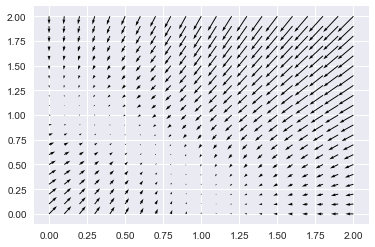

In [6]:
# Quiver plot
values = np.linspace(0, 2, 21)
x, y = np.meshgrid(values, values)

state_dict_grid = {'u': x.ravel(), 'v': y.ravel()}
udots = find_u_dot(state_dict_grid, param_dict_theta)
vdots = find_v_dot(state_dict_grid, param_dict_theta)

udotsr = np.reshape(udots, x.shape)
vdotsr = np.reshape(vdots, y.shape)

plt.quiver(x, y, udotsr, vdotsr)

#plt.savefig('quiver.pdf')


Fixed point coordinates are:  0.957834758364 0.279486824449


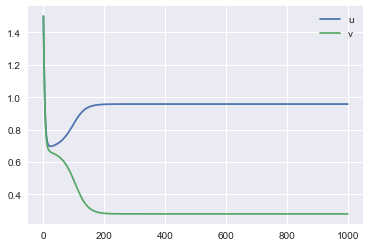

In [7]:
# Find fixed points for high theta
init_dict = {'u': 1.5, 'v': 1.5}
ulst_theta, vlst_theta = simulate_u_v_exp(init_dict, param_dict_theta, niter=1000)
plt.plot(ulst_theta, label='u')
plt.plot(vlst_theta, label='v')
plt.legend()
print('Fixed point coordinates are: ', ulst_theta[-1], vlst_theta[-1])

# Store the fixed points as dictionaries
stable1_theta = {'u': ulst_theta[-1], 'v': vlst_theta[-1]}
stable2_theta = {'v': ulst_theta[-1], 'u': vlst_theta[-1]}

In [8]:
# Plot the udots and vdots
ulst_arr = np.array(ulst_theta)
vlst_arr = np.array(vlst_theta)
state_arr = {'u': ulst_arr, 'v': vlst_arr}
udotlst = find_u_dot(state_arr, param_dict_theta)
vdotlst = find_v_dot(state_arr, param_dict_theta)



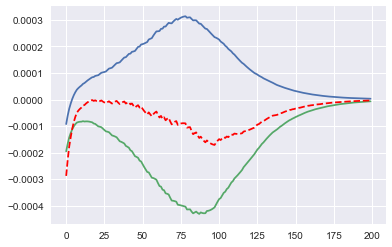

In [9]:
plt.plot(udotlst[20:220])
plt.plot(vdotlst[20:220])
plt.plot(udotlst[20:220] + vdotlst[20:220], 'r--')

Working on theta =  0.0
Working on theta =  0.1
Working on theta =  0.2
Working on theta =  0.3
Working on theta =  0.4
Working on theta =  0.5
Working on theta =  0.6
Working on theta =  0.7
Working on theta =  0.8
Working on theta =  0.9
Working on theta =  1.0
Working on theta =  1.1
Working on theta =  1.2
Working on theta =  1.3


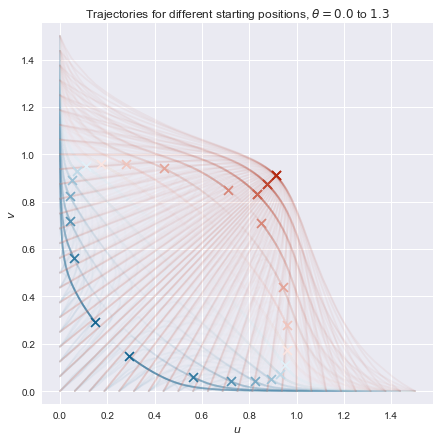

In [10]:
# Find trajectories for various starting points and various thetas
plt.figure(figsize=(7, 7))
theta_lst = np.arange(0, 1.4, 0.1)
col_lst = sns.diverging_palette(240, 15, s=95, l=40,
                                n=len(theta_lst), center="light")

for idx, theta in enumerate(theta_lst):
    print('Working on theta = ', theta)
    param_dict_traj = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta, 'tau': 100, 'dt': 10, 'ext': 0}
    values = np.linspace(0, 1.5, 25);
    for i in values:
        for j in values:
            if i == 0 or j == 0 or i == 2 or j == 2:
                init_dict = {'u': i, 'v': j}
                ulst_theta, vlst_theta = simulate_u_v_exp(init_dict, param_dict_traj, niter=1000)
                plt.plot(ulst_theta, vlst_theta, 'b', alpha=0.05, color=col_lst[idx])

    # Plot the fixed points
    stable1 = ulst_theta[-1]
    stable2 = vlst_theta[-1]
    plt.scatter([stable1, stable2], [stable2, stable1], 
                marker='x', s=80, zorder=5, color=col_lst[idx])
    plt.xlabel(r'$u$')
    plt.ylabel(r'$v$')

plt.xlim([0, 2])
plt.axis('equal')
#plt.ylim([0, 2])
plt.title(r'Trajectories for different starting positions, $\theta=0.0$ to $1.3$')
#plt.savefig('trajectories_all_theta.pdf')

In [11]:
def udot_fun(u, a, theta, target):
    return u - 1 / (1 + np.exp(a * u - theta)) - target

def find_corridor(v_vals, params):
    '''For drawing the corridor'''
    Wuv = params['Wuv']
    theta_val = params['theta'] * params['Wut']
    ulst_corr = []
    for v in v_vals:
        target_val = -udot_fun(v, Wuv, theta_val, 0)
        uval = scipy.optimize.fsolve(udot_fun, x0=0.5, args=(Wuv, theta_val, target_val))
        ulst_corr.append(uval[0])
    return ulst_corr

def find_null_cline(v_vals, params):
    ''' For drawing the null clines'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    theta = params['theta']
    return 1 / (1 + np.exp(Wuv * v_vals - Wut * theta))

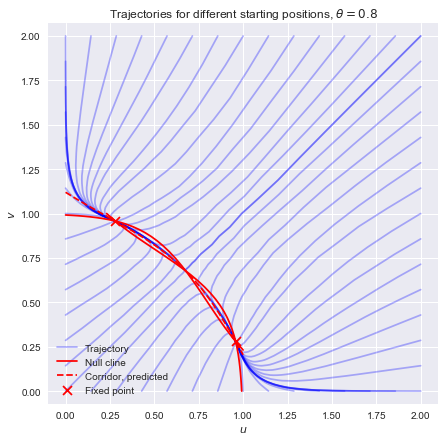

In [12]:
param_dict_single = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

# Prediction of null-clines and corridor
vlst_corridor = np.linspace(0, 1, 30)
ulst_corridor = find_corridor(vlst_corridor, param_dict_single)
ulst_null_cline = find_null_cline(vlst_corridor, param_dict_single)


# Find trajectories for various starting points
plt.figure(figsize=(7, 7))
values = np.linspace(0, 2, 15);
for i in values:
    for j in values:
        if i == 0 or j == 0 or i == 2 or j == 2:
            init_dict = {'u': i, 'v': j}
            ulst_theta, vlst_theta = simulate_u_v_exp(init_dict, param_dict_single, niter=1000)
            plt.plot(ulst_theta, vlst_theta, 'b', alpha=0.3)
plt.plot(ulst_theta, vlst_theta, 'b', alpha=0.3, label='Trajectory')
# Plot the fixed points
stable1 = ulst_theta[-1]
stable2 = vlst_theta[-1]
plt.scatter([stable1, stable2], [stable2, stable1], color='r', 
            marker='x', s=80, zorder=5, label='Fixed point')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

# Plot theoretical corridor
plt.plot(vlst_corridor, ulst_null_cline, 'r')
plt.plot(ulst_null_cline, vlst_corridor, 'r', label='Null cline')
plt.plot(vlst_corridor, ulst_corridor, 'r--', label='Corridor, predicted')

plt.xlim([0, 2])
plt.axis('equal')
#plt.ylim([0, 2])
plt.title(r'Trajectories for different starting positions, $\theta=0.8$')
plt.legend(loc='lower left')

plt.savefig('trajectories_0_8_theta.pdf')

Fixed point coordinates are:  0.950055797413 0.109064286175


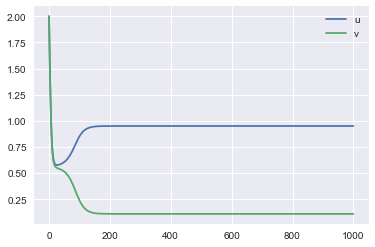

In [13]:
# Find fixed points for low theta
ulst_no_theta, vlst_no_theta = simulate_u_v_exp(init_dict, param_dict_no_theta, niter=1000)
plt.plot(ulst_no_theta, label='u')
plt.plot(vlst_no_theta, label='v')
plt.legend()
print('Fixed point coordinates are: ', ulst_no_theta[-1], vlst_no_theta[-1])

# Store the fixed points as dictionaries
stable1_no_theta = {'u': ulst_no_theta[-1], 'v': vlst_no_theta[-1]}
stable2_no_theta = {'v': ulst_no_theta[-1], 'u': vlst_no_theta[-1]}


In [14]:
def find_path_integral_line(state1, state2, params, nsteps):
    '''Perform the path integral along a straight line from 
    state1 to state2, taking n steps
    Returns the total integral, together with the cumulative list of integrals
    along the path'''
    u_ids = np.linspace(state1['u'], state2['u'], nsteps)
    v_ids = np.linspace(state1['v'], state2['v'], nsteps)
    
    integral, integrals = find_path_integral_list(u_ids, v_ids, params)
        
    return integral, np.array(integrals)
        
    
def find_path_integral_list(u_pos_list, v_pos_list, params):
    '''Perform the path integral along an arbitrary line parameterized by
    u_pos_list and v_pos_list, taking n steps
    Returns the total integral, together with the cumulative list of integrals
    along the path'''    
    # Variables for storage
    integral = 0
    integrals = [0]
    nsteps = len(u_pos_list)
    
    for i in range(nsteps - 1):
        ustart = u_pos_list[i]
        uend = u_pos_list[i + 1]
        vstart = v_pos_list[i]
        vend = v_pos_list[i + 1]
        
        start_state = {'u': ustart, 'v': vstart}
        
        udot = find_u_dot(start_state, params)
        vdot = find_v_dot(start_state, params)
        
        du = uend - ustart
        dv = vend - vstart
        
        integral -= udot * du + vdot * dv
        integrals.append(integral)
        
    return integral, np.array(integrals)
    

In [15]:
stable1arr_theta = np.array([stable1_theta['u'], stable1_theta['v']])
stable2arr_theta = np.array([stable2_theta['u'], stable2_theta['v']])
startpt_theta = stable1arr_theta - 0.1 * (stable2arr_theta - stable1arr_theta)
endpt_theta = stable2arr_theta + 0.1 * (stable2arr_theta - stable1arr_theta)
startpt_dict_theta = {'u': startpt_theta[0], 'v': startpt_theta[1]}
endpt_dict_theta = {'u': endpt_theta[0], 'v': endpt_theta[1]}

stable1arr_no_theta = np.array([stable1_no_theta['u'], stable1_no_theta['v']])
stable2arr_no_theta = np.array([stable2_no_theta['u'], stable2_no_theta['v']])
startpt_no_theta = stable1arr_no_theta - 0.1 * (stable2arr_no_theta - stable1arr_no_theta)
endpt_no_theta = stable2arr_no_theta + 0.1 * (stable2arr_no_theta - stable1arr_no_theta)
startpt_dict_no_theta = {'u': startpt_no_theta[0], 'v': startpt_no_theta[1]}
endpt_dict_no_theta = {'u': endpt_no_theta[0], 'v': endpt_no_theta[1]}

integral_theta_short, integrals_theta_short = find_path_integral_line(stable1_theta, stable2_theta, 
                                                param_dict_theta, 1000)
integral_theta_long, integrals_theta_long = find_path_integral_line(startpt_dict_theta, endpt_dict_theta, 
                                                param_dict_theta, 1000)
integral_notheta_short, integrals_notheta_short = find_path_integral_line(stable1_no_theta, stable2_no_theta, 
                                                param_dict_no_theta, 1000)
integral_notheta_long, integrals_notheta_long = find_path_integral_line(startpt_dict_no_theta, 
                                                endpt_dict_no_theta, param_dict_no_theta, 1000)


difference, _ = find_path_integral_line(startpt_dict_theta, startpt_dict_no_theta, param_dict_theta, 1000)

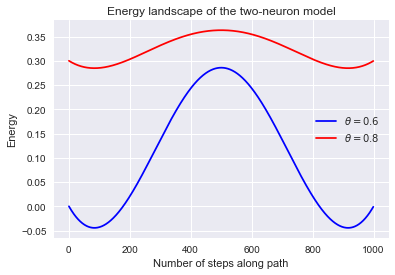

In [16]:
plt.plot(integrals_notheta_long * 1000, 'b', label=r'$\theta=0.6$')
plt.plot(integrals_theta_long * 1000 + 0.3, 'r', label=r'$\theta=0.8$')
plt.xlabel('Number of steps along path')
plt.ylabel('Energy')
plt.title('Energy landscape of the two-neuron model')
plt.legend()
#plt.savefig('energy_landscape.pdf')


## Energy landscapes for various values of $\theta$

In [17]:
integral_set = []
theta_vals = np.linspace(0, 1, 11)
fixed_points = np.zeros((len(theta_vals), 2))
for idx, theta_val in enumerate(theta_vals):
    print('Doing theta = ', theta_val)
    # Create the parameter dictionary
    param_dict_theta_val = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta_val, 'tau': 100, 'dt': 10, 'ext': 0}
    
    # Do simulation to find fixed points
    # Find fixed points for high theta
    init_dict = {'u': 0.22, 'v': 0.22}
    ulst_theta_val, vlst_theta_val = simulate_u_v_exp(init_dict, param_dict_theta_val, niter=1000)
    
    # Store fixed points
    fixed_points[idx, 0] = ulst_theta_val[-1]
    fixed_points[idx, 1] = vlst_theta_val[-1]
    stable1_theta_val = {'u': ulst_theta_val[-1], 'v': vlst_theta_val[-1]}
    stable2_theta_val = {'v': ulst_theta_val[-1], 'u': vlst_theta_val[-1]}

    # Perform the path integral. First set up relevant starting points
    stable1arr_theta_val = np.array([stable1_theta_val['u'], stable1_theta_val['v']])
    stable2arr_theta_val = np.array([stable2_theta_val['u'], stable2_theta_val['v']])
    startpt_theta_val = stable1arr_theta_val - 0.1 * (stable2arr_theta_val - stable1arr_theta_val)
    endpt_theta_val = stable2arr_theta_val + 0.1 * (stable2arr_theta_val - stable1arr_theta_val)
    startpt_dict_theta_val = {'u': startpt_theta_val[0], 'v': startpt_theta_val[1]}
    endpt_dict_theta_val = {'u': endpt_theta_val[0], 'v': endpt_theta_val[1]}

    # Then do integral...
    _, integrals_theta_val = find_path_integral_line(startpt_dict_theta_val, endpt_dict_theta_val, 
                                                    param_dict_theta_val, 1000)
    integral_set.append(integrals_theta_val)

Doing theta =  0.0
Doing theta =  0.1
Doing theta =  0.2
Doing theta =  0.3
Doing theta =  0.4
Doing theta =  0.5
Doing theta =  0.6
Doing theta =  0.7
Doing theta =  0.8
Doing theta =  0.9
Doing theta =  1.0


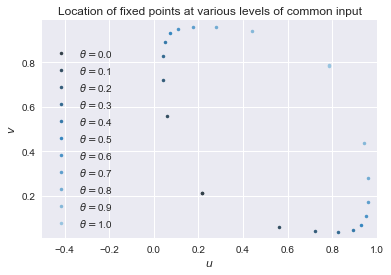

In [18]:
with sns.color_palette("Blues_d", len(theta_vals)):
    for i in range(len(theta_vals)):
        plt.plot(fixed_points[i, 0], fixed_points[i, 1], '.', 
                 label=r'$\theta=$' + str(theta_vals[i]))

with sns.color_palette("Blues_d", len(theta_vals)):
    for i in range(len(theta_vals)):
        plt.plot(fixed_points[i, 1], fixed_points[i, 0], '.')
    
# Plot y=x line
xcoords = np.linspace(0, 1, 100)
#plt.plot(xcoords, xcoords, 'k--')

plt.legend(loc='lower left')    
plt.axis('equal');
plt.xlim([-0.5, 1]);
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.title('Location of fixed points at various levels of common input')
#plt.savefig('fixed_pt_loc.pdf')

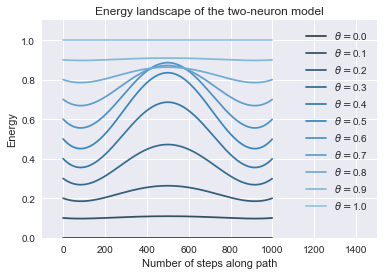

In [19]:
with sns.color_palette("Blues_d", len(theta_vals)):
    for idx, series in enumerate(integral_set):
        plt.plot(series* 1000 + idx * 0.1, label=r'$\theta=$' + str(theta_vals[idx]))
    plt.xlim(-100, 1500)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper right')
    plt.xlabel('Number of steps along path')
    plt.ylabel('Energy')
    plt.title('Energy landscape of the two-neuron model')

#plt.savefig('energy_landscape_theta.pdf')

In [20]:
def update_u_exp_noise(u, v, c1, c2, c3, theta, tau, dt):
    '''Update neuron u given a noise that is ~N(0, s^2)'''
    noise = np.random.normal(scale=0.01, size=len(u))
    du = (-u + thresh_exp(c3 * theta - c1 * v) + noise) / tau * dt
    return u + du

def update_v_exp_noise(u, v, c1, c2, c3, theta, tau, dt):
    '''Update neuron v given a noise that is ~N(0, s^2)'''
    noise = np.random.normal(scale=0.01, size=len(v))
    dv = (-v + thresh_exp(c3 * theta - c2 * u) + noise) / tau * dt
    return v + dv

def simulate_u_v_exp_noise(u_init, v_init, c1, c2, c3, theta, tau, niter, dt):
    u_lst = []
    v_lst = []
    u = u_init
    v = v_init
    for i in range(niter):
        u = update_u_exp_noise(u, v, c1, c2, c3, theta, tau, dt)
        #print('u = ', u)
        u_lst.append(u)
        v = update_v_exp_noise(u, v, c1, c2, c3, theta, tau, dt)
        #print('v = ', v)
        v_lst.append(v)
    return u_lst, v_lst

## For simultaneous simulation (faster)

In [101]:
def find_u_dot_multi(state, params):
    '''Returns du/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(u))
    return (-u + thresh_exp(Wut * theta - Wuv * v + noise + ext)) / tau

def find_v_dot_multi(state, params):
    '''Returns dv/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(v))
    return (-v + thresh_exp(Wvt * theta - Wvu * u + noise + ext)) / tau

def update_u_exp_multi(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u']= state_new['u'] + find_u_dot_multi(state, params) * params['dt']
    return state_new

def update_v_exp_multi(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] = state_new['v'] + find_v_dot_multi(state, params) * params['dt']
    return state_new

def simulate_u_v_exp_multi(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2) # Choose to update u or v first
        if order:
            curr_state = update_u_exp_multi(curr_state, params)
            curr_state = update_v_exp_multi(curr_state, params) 
        else:
            curr_state = update_v_exp_multi(curr_state, params)
            curr_state = update_u_exp_multi(curr_state, params) 
        u_lst.append(curr_state['u'])
        v_lst.append(curr_state['v'])
        
    u_arr = np.vstack(u_lst)
    v_arr = np.vstack(v_lst)
    return u_arr, v_arr

In [22]:
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / len(data)

In [23]:
def get_mean_and_sd_lines(state, params, nstep):
    '''Simulate for n steps and return two arrays, one for mean
    and one for SD across all trials'''
    ulst, vlst = simulate_u_v_exp_multi(state, params, nstep)
    return np.mean(ulst, axis=1), np.mean(vlst, axis=1), \
            np.std(ulst, axis=1), np.std(vlst, axis=1)

Visualize the mean trajectory at different noise levels

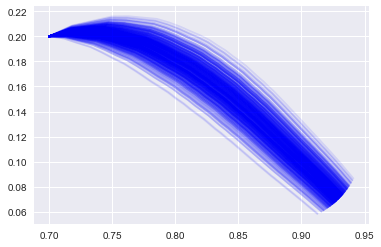

In [115]:
ntrials = 500
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': np.random.normal(loc=0, scale=0.1,
                size=ntrials), 'sigma': 0.0}

sigma_vals = np.arange(0, 1, 0.1)
ulst, vlst = simulate_u_v_exp_multi(state_dict, param_dict_noise, 800)
#plt.plot(ulst)
plt.plot(ulst, vlst, 'b', alpha=0.1);

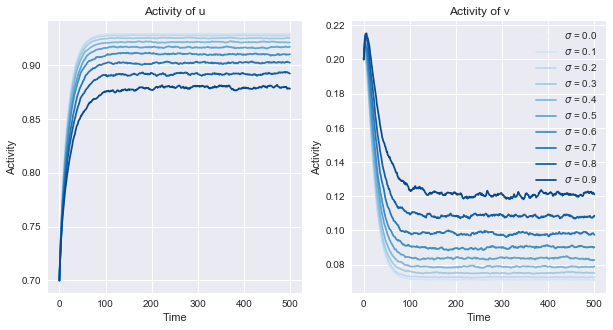

In [24]:
ntrials = 500
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.0}

sigma_vals = np.arange(0, 1, 0.1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
palette = sns.color_palette("Blues", len(sigma_vals))
mean_lst = np.zeros(len(sigma_vals))
std_lst = np.zeros(len(sigma_vals))

for idx, sigma in enumerate(sigma_vals):
    param_dict_noise['sigma'] = sigma
    umean_hnoise_hinput, vmean_hnoise_hinput, ustd_hnoise_hinput, vstd_hnoise_hinput = \
        get_mean_and_sd_lines(state_dict, param_dict_noise, 500)
    mean_lst[idx] = umean_hnoise_hinput[-1]
    std_lst[idx] = ustd_hnoise_hinput[-1]
    ax[0].plot(umean_hnoise_hinput, color=palette[idx])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Activity')
    ax[0].set_title('Activity of u')
    ax[1].plot(vmean_hnoise_hinput, color=palette[idx], label=r'$\sigma$ = ' + str(sigma))
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Activity')
    ax[1].set_title('Activity of v')
    plt.legend(loc='upper right')

#plt.savefig('noise_effect_theta_0_5.pdf')


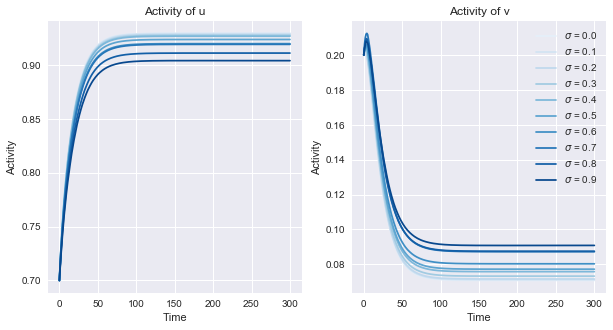

In [119]:
ntrials = 1000
nsteps = 300
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.0}

sigma_vals = np.arange(0, 1, 0.1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
palette = sns.color_palette("Blues", len(sigma_vals))
mean_lst = np.zeros(len(sigma_vals))
std_lst = np.zeros(len(sigma_vals))

for idx, sigma in enumerate(sigma_vals):
    extlst = np.random.normal(loc=0, scale=sigma, size=ntrials)
    param_dict_noise['ext'] = extlst
    umean_hnoise_hinput, vmean_hnoise_hinput, ustd_hnoise_hinput, vstd_hnoise_hinput = \
        get_mean_and_sd_lines(state_dict, param_dict_noise, nsteps)
    mean_lst[idx] = umean_hnoise_hinput[-1]
    std_lst[idx] = ustd_hnoise_hinput[-1]
    ax[0].plot(umean_hnoise_hinput, color=palette[idx])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Activity')
    ax[0].set_title('Activity of u')
    ax[1].plot(vmean_hnoise_hinput, color=palette[idx], label=r'$\sigma$ = ' + str(sigma))
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Activity')
    ax[1].set_title('Activity of v')
    plt.legend(loc='upper right')
    
save_safe('noise_effect_theta_mu_theta_0_5.pdf')

Visualize the equilibrium distribution at different noise levels 

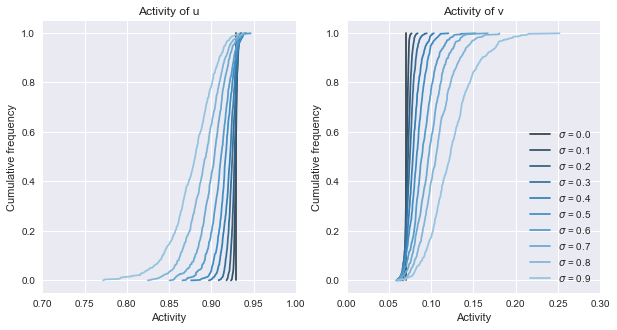

In [25]:
ntrials = 500
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

sigma_vals = np.arange(0, 1, 0.1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
palette = sns.color_palette("Blues_d", len(sigma_vals))

for idx, sigma in enumerate(sigma_vals):
    param_dict_noise['sigma'] = sigma
    ulst1, vlst1 = simulate_u_v_exp_multi(state_dict, param_dict_noise, 600)
    
    # Plot ecdf for both u and v
    x1, y1 = ecdf(ulst1[-1,:])
    ax[0].plot(x1, y1, color=palette[idx], label=r'$\sigma$ = ' + str(sigma))
    x2, y2 = ecdf(vlst1[-1,:])
    ax[1].plot(x2, y2, color=palette[idx], label=r'$\sigma$ = ' + str(sigma))
    
    ax[0].set_xlabel('Activity')
    ax[0].set_ylabel('Cumulative frequency')
    ax[1].set_xlabel('Activity')
    ax[1].set_ylabel('Cumulative frequency')
    ax[0].set_xlim(0.7, 1)
    ax[1].set_xlim(0, 0.3)
    
    ax[0].set_title('Activity of u')
    ax[1].set_title('Activity of v')
    
plt.legend(loc='lower right')
plt.savefig('distribution_noise.pdf')

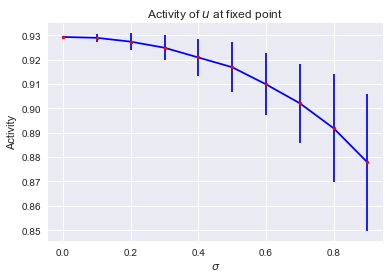

In [26]:
plt.plot(sigma_vals, mean_lst, '.', color='red', zorder=3)
plt.errorbar(sigma_vals, mean_lst, yerr=std_lst, color='blue')
plt.xlabel(r'$\sigma$')
plt.ylabel('Activity')
plt.title(r'Activity of $u$ at fixed point')
#plt.savefig('noise_error_bar.pdf')

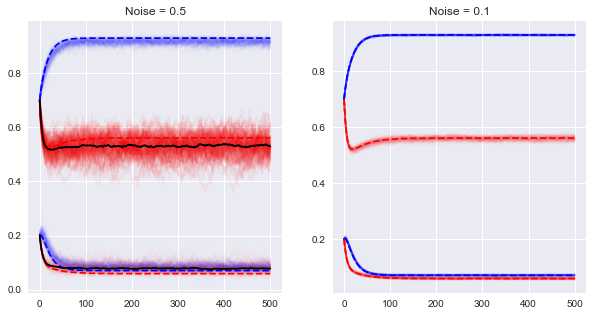

In [27]:
state_dict = {'u': np.array([0.7] * 100), 'v': np.array([0.2] * 100)}
state_dict_single = {'u': np.array([0.7]), 'v': np.array([0.2])}

high_noise = 0.5
low_noise = 0.1
no_noise = 0

high_input = 0.5
low_input = 0.1


####### HIGH INPUT #########
# High noise, high input
param_dict_theta['sigma'] = high_noise
param_dict_theta['theta'] = high_input
ulst_hnoise_hinput, vlst_hnoise_hinput = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)

# Low noise, high input
param_dict_theta['sigma'] = low_noise
param_dict_theta['theta'] = high_input
ulst_lnoise_hinput, vlst_lnoise_hinput = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)

# No noise, high input
param_dict_theta['sigma'] = no_noise
param_dict_theta['theta'] = high_input
ulst_nnoise_hinput, vlst_nnoise_hinput = simulate_u_v_exp_multi(state_dict_single, param_dict_theta, 500)


####### LOW INPUT #########
# High noise, low input
param_dict_theta['sigma'] = high_noise
param_dict_theta['theta'] = low_input
ulst_hnoise_linput, vlst_hnoise_linput = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)

# Low noise, low input
param_dict_theta['sigma'] = low_noise
param_dict_theta['theta'] = low_input
ulst_lnoise_linput, vlst_lnoise_linput = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)

# No noise, low input
param_dict_theta['sigma'] = no_noise
param_dict_theta['theta'] = low_input
ulst_nnoise_linput, vlst_nnoise_linput = simulate_u_v_exp_multi(state_dict_single, param_dict_theta, 500)


######### PLOTTING FOR HIGH NOISE ############
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(ulst_hnoise_hinput, 'b', alpha=0.01);
ax[0].plot(vlst_hnoise_hinput, 'b', alpha=0.01);
ax[0].plot(ulst_hnoise_linput, 'r', alpha=0.05);
ax[0].plot(vlst_hnoise_linput, 'r', alpha=0.01);

# Compare with no noise
ax[0].plot(ulst_nnoise_hinput, 'b--')
ax[0].plot(vlst_nnoise_hinput, 'b--')
ax[0].plot(ulst_nnoise_linput, 'r--')
ax[0].plot(vlst_nnoise_linput, 'r--')
ax[0].set_title('Noise = 0.5')

# Mean traces
#ax[0].plot(np.mean(ulst_hnoise_hinput, axis=1), 'k')
#ax[0].plot(np.mean(vlst_hnoise_hinput, axis=1), 'k')
ax[0].plot(np.mean(ulst_hnoise_linput, axis=1), 'k')
ax[0].plot(np.mean(vlst_hnoise_linput, axis=1), 'k')

######### PLOTTING FOR LOW NOISE ############
# High and low inputs
ax[1].plot(ulst_lnoise_hinput, 'b', alpha=0.01);
ax[1].plot(vlst_lnoise_hinput, 'b', alpha=0.01);
ax[1].plot(ulst_lnoise_linput, 'r', alpha=0.01);
ax[1].plot(vlst_lnoise_linput, 'r', alpha=0.01);

# Compare with no noise
ax[1].plot(ulst_nnoise_hinput, 'b--')
ax[1].plot(vlst_nnoise_hinput, 'b--')
ax[1].plot(ulst_nnoise_linput, 'r--')
ax[1].plot(vlst_nnoise_linput, 'r--')

ax[1].set_title('Noise = 0.1')

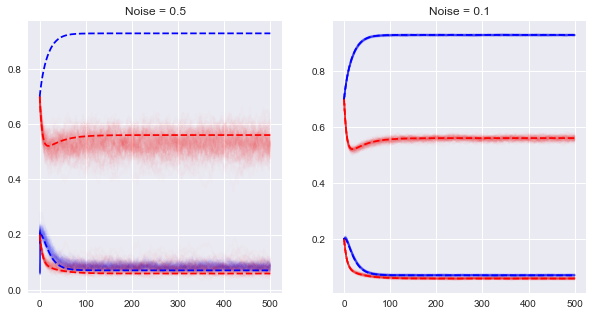

In [28]:
######### PLOTTING FOR HIGH NOISE ############
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(ulst_hnoise_hinput, vlst_hnoise_hinput, 'b', alpha=0.01);
ax[0].plot(vlst_hnoise_hinput, 'b', alpha=0.01);
ax[0].plot(ulst_hnoise_linput, 'r', alpha=0.01);
ax[0].plot(vlst_hnoise_linput, 'r', alpha=0.01);

# Compare with no noise
ax[0].plot(ulst_nnoise_hinput, 'b--')
ax[0].plot(vlst_nnoise_hinput, 'b--')
ax[0].plot(ulst_nnoise_linput, 'r--')
ax[0].plot(vlst_nnoise_linput, 'r--')
ax[0].set_title('Noise = 0.5')


######### PLOTTING FOR LOW NOISE ############
# High and low inputs
ax[1].plot(ulst_lnoise_hinput, 'b', alpha=0.01);
ax[1].plot(vlst_lnoise_hinput, 'b', alpha=0.01);
ax[1].plot(ulst_lnoise_linput, 'r', alpha=0.01);
ax[1].plot(vlst_lnoise_linput, 'r', alpha=0.01);

# Compare with no noise
ax[1].plot(ulst_nnoise_hinput, 'b--')
ax[1].plot(vlst_nnoise_hinput, 'b--')
ax[1].plot(ulst_nnoise_linput, 'r--')
ax[1].plot(vlst_nnoise_linput, 'r--')

ax[1].set_title('Noise = 0.1')

In [29]:
# Plot the mean and std of the distribution
v_means = np.mean(vlst_lnoise_hinput, axis=1)
u_means = np.mean(ulst_hnoise_hinput, axis=1)
v_std = np.std(vlst_lnoise_hinput, axis=1)
u_std = np.std(ulst_hnoise_hinput, axis=1)

v_means_low = np.mean(vlst_lnoise_linput, axis=1)
u_means_low = np.mean(ulst_hnoise_linput, axis=1)
v_std_low = np.std(vlst_lnoise_linput, axis=1)
u_std_low = np.std(ulst_hnoise_linput, axis=1)

(0, 1.2)

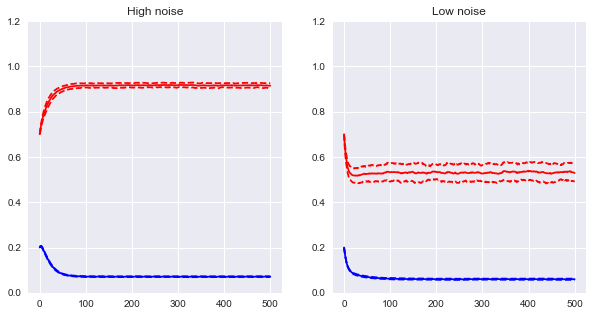

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
# High noise
ax[0].plot(v_means, 'b')
ax[0].plot(u_means, 'r')

ax[0].plot(v_means + v_std, 'b--')
ax[0].plot(v_means - v_std, 'b--')
ax[0].plot(u_means + u_std, 'r--')
ax[0].plot(u_means - u_std, 'r--')
ax[0].set_ylim([0, 1.2])
ax[0].set_title('High noise')

# Low noise
ax[1].plot(v_means_low, 'b')
ax[1].plot(u_means_low, 'r')

ax[1].plot(v_means_low + v_std_low, 'b--')
ax[1].plot(v_means_low - v_std_low, 'b--')
ax[1].plot(u_means_low + u_std_low, 'r--')
ax[1].plot(u_means_low - u_std_low, 'r--')
ax[1].set_title('Low noise')
ax[1].set_ylim([0, 1.2])


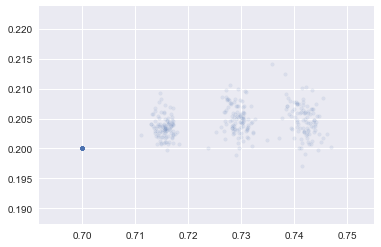

In [31]:
# Cool plot showing the position after the first 4 steps of the simulation
plt.scatter(np.ravel(ulst_lnoise_hinput[0:4,:]), 
            np.ravel(vlst_lnoise_hinput[0:4,:]), marker='.', alpha=0.1);

## Effect of $\sigma_\sigma$

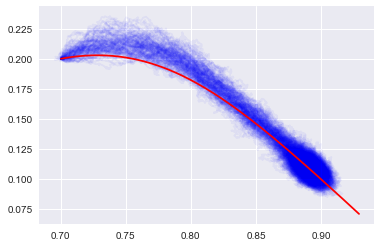

In [85]:
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.8}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * 100), 'v': np.array([0.2] * 100)}
state_dict_single = {'u': np.array([0.7]), 'v': np.array([0.2])}

ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict_single, param_dict_no_noise, 5000)

plt.plot(ulst_noise, vlst_noise, 'b', alpha=0.05);
plt.plot(ulst_no_noise, vlst_no_noise, 'r');


### Quantify time stretching by determining the closest neighbor

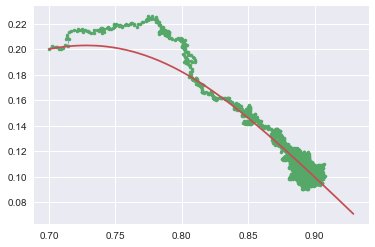

In [120]:
tlen = 5000
unoise_single = ulst_noise[:tlen, 0]
vnoise_single = vlst_noise[:tlen, 0]

uno_single = ulst_no_noise[:tlen, 0]
vno_single = vlst_no_noise[:tlen, 0]

plt.plot(unoise_single, vnoise_single, linewidth=0.5)
plt.plot(unoise_single, vnoise_single, '.')
plt.plot(uno_single, vno_single)

In [34]:
def find_closest_point(xlst, ylst, target):
    '''Given path (a list of (x,y) coordinates) and a target point,
    returns a point on the path that is closest to the target'''
    dx = xlst - target[0]
    dy = ylst - target[1]
    dist = dx**2 + dy**2
    return np.argmin(dist)

def get_standard_stamps(upath, vpath, uref, vref):
    '''Inputs: upath, vpath: np arrays corresponding to noisy paths
    at a certain noise level
    uref, vref: reference path
    Returns the reference timestamps corresponding to the array'''
    stamps_all = np.zeros_like(upath)
    for path_id in range(upath.shape[1]):
        unoise_single = upath[:, path_id]
        vnoise_single = vpath[:, path_id]

        stamps_all[:, path_id] = [find_closest_point(unoise_single, vnoise_single, targetpt) \
             for targetpt in zip(uref, vref)]
    return stamps_all
    
    

Working on noise =  0.0
Working on noise =  0.2


KeyboardInterrupt: 

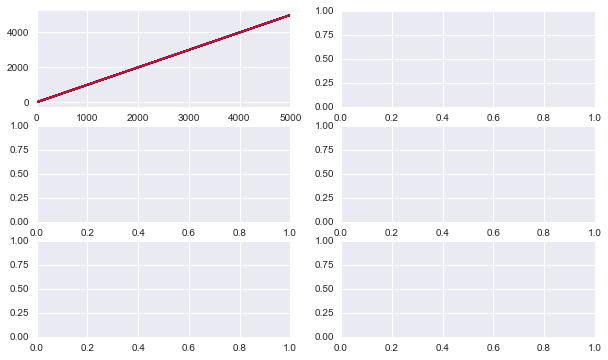

In [35]:
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

# Plot the time stretch
noise_lst = np.arange(0, 1.2, 0.2)
tlength = 5000
ncols = 2
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 6))
uno_single, vno_single = simulate_u_v_exp_multi(state_dict_single, param_dict_no_noise, 4999)

for i in range(nrows):
    for j in range(ncols):
        noise = noise_lst[ncols * i + j]
        print('Working on noise = ', noise)
        param_dict_noise['sigma'] = noise
        ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 4999)
        std_stamps = get_standard_stamps(ulst_noise, vlst_noise, uno_single, vno_single)
        meanline = np.mean(std_stamps, axis=1)
        ax[i][j].plot(std_stamps[:tlength,:], 'b', alpha=0.1);
        ax[i][j].plot(np.arange(tlength), np.arange(tlength), 'g--')
        ax[i][j].plot(meanline[:tlength], 'r')
        #ax[i][j].set_ylim(0, 200)
        ax[i][j].set_xlim(0, tlength)
        #ax[i][j].text(0, 100, r'$\sigma=$' + str(noise), fontsize=15)
        #ax[i][j].set_title(r'\sigma = ' + str(noise))
        if i == nrows - 1 and j == 0:
            ax[i][j].set_xlabel(r'$t_{ref}$')
            ax[i][j].set_ylabel(r'$t_i$')

filename = 'timestamps_reference_noise_dt1_171114.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    raise IOError('File exists!')

### Define a threshold for a behavior read-out

Plot distribution of timing as histograms

Working on noise =  0.0
Working on noise =  0.1
Working on noise =  0.2
Working on noise =  0.3
Working on noise =  0.4
Working on noise =  0.5
Working on noise =  0.6
Working on noise =  0.7
Working on noise =  0.8
Working on noise =  0.9


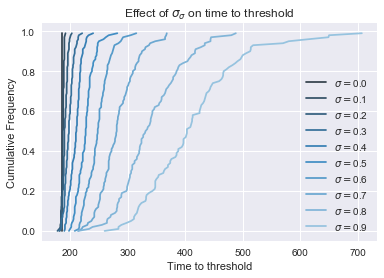

In [178]:
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.1}

# Plot the time stretch
noise_lst = np.arange(0, 1.2, 0.1)
tlength = 100
ncols = 2
nrows = 5
#fig, ax = plt.subplots(nrows, ncols, figsize=(10, 6))

# Threshold for behavior
thresh = 0.85
action_times = np.zeros((len(noise_lst), 100))

for i in range(nrows):
    for j in range(ncols):
        noise = noise_lst[ncols * i + j]
        print('Working on noise = ', noise)
        param_dict_noise['sigma'] = noise
        ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)
        
        # Find time to act
        for k in range(100):
            # Check if the bound is reached (sometimes it's not!)
            if np.max(ulst_noise[:,k]) > thresh:
                action_times[ncols * i + j][k] = np.nonzero(ulst_noise[:, k] > thresh)[0][0]
            else:
                print('Bound not reached')
        x, y = ecdf(action_times[ncols * i + j])
        plt.plot(x, y, color=palette[ncols * i + j], label=r'$\sigma = $' + str(noise))
        
plt.xlabel('Time to threshold')
plt.ylabel('Cumulative Frequency')
plt.title(r'Effect of $\sigma_\sigma$ on time to threshold')
plt.legend()

save_safe('sigma_sigma_cum_freq_thresh_0-85_theta_0-5.pdf')
        #ax[i][j].hist(action_times[ncols * i +j, :]);
        
        #ax[i][j].text(0, 400, r'$\sigma=$' + str(noise), fontsize=15)
        #ax[i][j].set_title(r'\sigma = ' + str(noise))
        #if i == nrows - 1 and j == 0:
        #    ax[i][j].set_xlabel(r'$t_{ref}$')
        #    ax[i][j].set_ylabel(r'$t_i$')

Working on noise_mu =  0.0 , ext =  0.0
Working on noise_mu =  0.0666666666667 , ext =  0.0
Working on noise_mu =  0.133333333333 , ext =  0.0
Working on noise_mu =  0.2 , ext =  0.0
Working on noise_mu =  0.266666666667 , ext =  0.0
Working on noise_mu =  0.333333333333 , ext =  0.0
Working on noise_mu =  0.4 , ext =  0.0
Working on noise_mu =  0.466666666667 , ext =  0.0
Working on noise_mu =  0.533333333333 , ext =  0.0
Working on noise_mu =  0.6 , ext =  0.0
Working on noise_mu =  0.0 , ext =  0.2
Working on noise_mu =  0.0666666666667 , ext =  0.2
Working on noise_mu =  0.133333333333 , ext =  0.2
Working on noise_mu =  0.2 , ext =  0.2
Working on noise_mu =  0.266666666667 , ext =  0.2
Working on noise_mu =  0.333333333333 , ext =  0.2
Working on noise_mu =  0.4 , ext =  0.2
Working on noise_mu =  0.466666666667 , ext =  0.2
Working on noise_mu =  0.533333333333 , ext =  0.2
Working on noise_mu =  0.6 , ext =  0.2
Working on noise_mu =  0.0 , ext =  0.4
Working on noise_mu =  0.0

OSError: File exists!

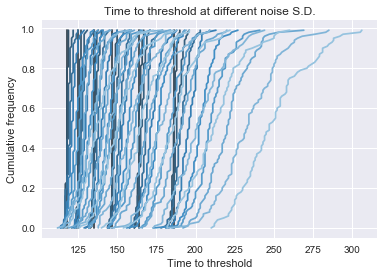

In [130]:
# Cumulative distributions
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

# Plot the time stretch
noise_lst = np.linspace(0, 0.6, 10)
ext_lst = np.linspace(0, 1, 6)
tlength = 100
ncols = 2
nrows = 5

# Threshold for behavior
thresh = 0.85
action_times = np.zeros((len(noise_lst), 100))
palette = sns.color_palette("Blues_d", len(noise_lst))
all_means = np.zeros((len(noise_lst), len(ext_lst)))
all_std_devs = np.zeros((len(noise_lst), len(ext_lst)))

for iext, extern in enumerate(ext_lst):
    param_dict_noise['ext'] = extern
    for i, noise_sigma in enumerate(noise_lst):
        print('Working on noise_mu = ', noise_sigma, ', ext = ', extern)
        
        param_dict_noise['sigma'] = noise_sigma
        ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)

        action_times = []
        # Find time to act
        for k in range(100):
            # Check if the bound is reached (sometimes it's not!)
            if np.max(ulst_noise[:,k]) > thresh:
                action_times.append(np.nonzero(ulst_noise[:, k] > thresh)[0][0])
            else:
                action_times.append(np.inf)
                print('Bound not reached')

        all_means[i][iext] = np.median(action_times)
        all_std_devs[i][iext] = np.std(action_times)

        x, y = ecdf(np.array(action_times))
        #plt.plot(x, y, color=palette[i], label=r'$\sigma=$' + str(noise))

plt.xlabel('Time to threshold')
plt.ylabel('Cumulative frequency')
plt.title('Time to threshold at different noise S.D.')
#plt.legend()
    
save_safe('time_to_threshold_ecdf_sigmas.pdf')

OSError: File exists!

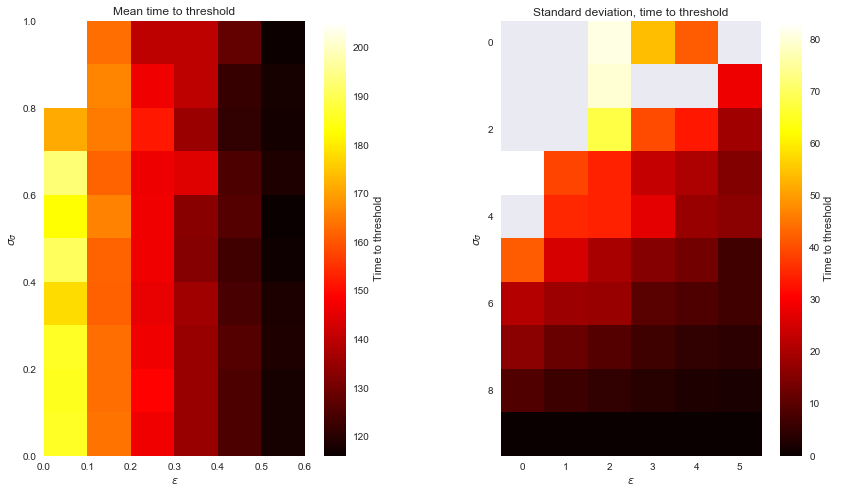

In [184]:
plt.figure(figsize=(15, 8))
plt.subplot('121')
plt.imshow(np.flipud(all_means), cmap=plt.cm.hot, extent=[0, 0.6, 0, 1])
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma_\sigma$')
plt.title('Mean time to threshold')
plt.grid(False)
plt.colorbar(label='Time to threshold')
#save_safe('time_to_thresh_sigma_sigma_ext_hot.pdf')

#plt.figure(figsize=(8, 8))
plt.subplot('122')
plt.imshow(np.flipud(all_std_devs), cmap=plt.cm.hot)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma_\sigma$')
plt.title('Standard deviation, time to threshold')
plt.grid(False)
plt.colorbar(label='Time to threshold')
save_safe('time_to_thresh_sd__sigma_sigma_ext_hot.pdf')

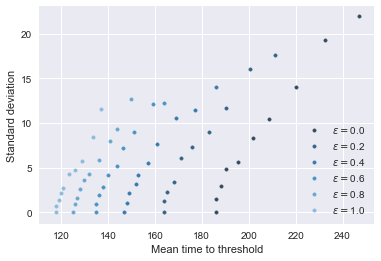

In [148]:
with sns.color_palette('Blues_d'):
    for iext in range(len(ext_lst)):
        mean_trial = all_means[:,iext].ravel()
        sd_trial = all_std_devs[:,iext].ravel()
        plt.scatter(mean_trial, sd_trial, marker='.', 
                    label=r'$\epsilon = $' + str(ext_lst[iext]))
        #regr = sklearn.linear_model.LinearRegression()
        #regr.fit(mean_trial[:20][:,np.newaxis], sd_trial[:20])
        #sd_pred = regr.predict(mean_trial[:,np.newaxis])
        #plt.plot(mean_trial, sd_pred)

#plt.ylim(0, 100)
#plt.xlim(0, 400)
plt.legend()
plt.xlabel('Mean time to threshold')
plt.ylabel('Standard deviation')
save_safe('mean_vs_std_sigma_sigma.pdf')

## Effect of $\sigma_\mu$

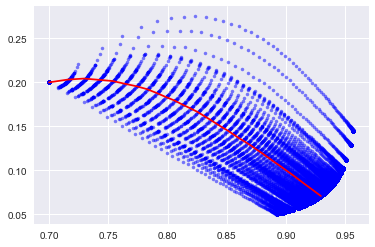

In [160]:
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': np.random.normal(loc=0, scale=0.3,
                                                    size=100), 'sigma': 0}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * 100), 'v': np.array([0.2] * 100)}
state_dict_single = {'u': np.array([0.7]), 'v': np.array([0.2])}

ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict_single, param_dict_no_noise, 5000)

plt.plot(ulst_noise, vlst_noise, 'b.', alpha=0.5);
plt.plot(ulst_no_noise, vlst_no_noise, 'r');

Working on noise =  0.0
Working on noise =  0.1
Working on noise =  0.2
Working on noise =  0.3
Working on noise =  0.4
Working on noise =  0.5
Working on noise =  0.6
Working on noise =  0.7
Working on noise =  0.8
Working on noise =  0.9


OSError: File exists!

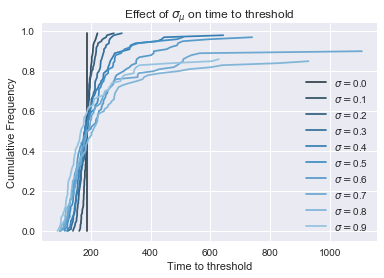

In [187]:
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

# Plot the time stretch
noise_lst = np.arange(0, 1.2, 0.1)
tlength = 100
ncols = 2
nrows = 5
#fig, ax = plt.subplots(nrows, ncols, figsize=(10, 6))

# Threshold for behavior
thresh = 0.85
action_times = np.nan + np.zeros((len(noise_lst), 100))

for i in range(nrows):
    for j in range(ncols):
        noise = noise_lst[ncols * i + j]
        print('Working on noise = ', noise)
        param_dict_noise['ext'] = np.random.normal(loc=0, scale=noise, size=100)
        ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)
        
        # Find time to act
        for k in range(100):
            # Check if the bound is reached (sometimes it's not!)
            if np.max(ulst_noise[:,k]) > thresh:
                action_times[ncols * i + j][k] = np.nonzero(ulst_noise[:, k] > thresh)[0][0]
            #else:
                #print('Bound not reached')
        
        x, y = ecdf(action_times[ncols * i + j])
        plt.plot(x, y, color=palette[ncols * i + j], label=r'$\sigma = $' + str(noise))
        
plt.xlabel('Time to threshold')
plt.ylabel('Cumulative Frequency')
plt.title(r'Effect of $\sigma_\mu$ on time to threshold')
plt.legend()

save_safe('sigma_mu_cum_freq_thresh_0-85_theta_0-5.pdf')
        #ax[i][j].hist(action_times[ncols * i +j, :]);
        
        #ax[i][j].text(0, 400, r'$\sigma=$' + str(noise), fontsize=15)
        #ax[i][j].set_title(r'\sigma = ' + str(noise))
        #if i == nrows - 1 and j == 0:
        #    ax[i][j].set_xlabel(r'$t_{ref}$')
        #    ax[i][j].set_ylabel(r'$t_i$')

In [189]:
# Cumulative distributions
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

# Plot the time stretch
noise_lst = np.linspace(0, 0.6, 10)
ext_lst = np.linspace(0, 1, 6)

# Threshold for behavior
thresh = 0.85
action_times = np.zeros((len(noise_lst), 100))
palette = sns.color_palette("Blues_d", len(noise_lst))
all_means = np.zeros((len(noise_lst), len(ext_lst)))
all_std_devs = np.zeros((len(noise_lst), len(ext_lst)))

for iext, extern in enumerate(ext_lst):
    for i, noise_sigma in enumerate(noise_lst):
        print('Working on noise_mu = ', noise_sigma, ', ext = ', extern)
        
        param_dict_noise['sigma'] = 0
        param_dict_noise['ext'] = np.random.normal(loc=extern, scale=noise_sigma,
                                                  size=100)
        ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)

        action_times = []
        # Find time to act
        for k in range(100):
            # Check if the bound is reached (sometimes it's not!)
            if np.max(ulst_noise[:,k]) > thresh:
                action_times.append(np.nonzero(ulst_noise[:, k] > thresh)[0][0])
            else:
                action_times.append(np.inf)
                #print('Bound not reached')

        all_means[i][iext] = np.median(action_times)
        all_std_devs[i][iext] = np.std(action_times)

Working on noise_mu =  0.0 , ext =  0.0
Working on noise_mu =  0.0666666666667 , ext =  0.0
Working on noise_mu =  0.133333333333 , ext =  0.0
Working on noise_mu =  0.2 , ext =  0.0
Working on noise_mu =  0.266666666667 , ext =  0.0
Working on noise_mu =  0.333333333333 , ext =  0.0
Working on noise_mu =  0.4 , ext =  0.0


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Working on noise_mu =  0.466666666667 , ext =  0.0
Working on noise_mu =  0.533333333333 , ext =  0.0
Working on noise_mu =  0.6 , ext =  0.0
Working on noise_mu =  0.0 , ext =  0.2
Working on noise_mu =  0.0666666666667 , ext =  0.2
Working on noise_mu =  0.133333333333 , ext =  0.2
Working on noise_mu =  0.2 , ext =  0.2
Working on noise_mu =  0.266666666667 , ext =  0.2
Working on noise_mu =  0.333333333333 , ext =  0.2
Working on noise_mu =  0.4 , ext =  0.2
Working on noise_mu =  0.466666666667 , ext =  0.2
Working on noise_mu =  0.533333333333 , ext =  0.2
Working on noise_mu =  0.6 , ext =  0.2
Working on noise_mu =  0.0 , ext =  0.4
Working on noise_mu =  0.0666666666667 , ext =  0.4
Working on noise_mu =  0.133333333333 , ext =  0.4
Working on noise_mu =  0.2 , ext =  0.4
Working on noise_mu =  0.266666666667 , ext =  0.4
Working on noise_mu =  0.333333333333 , ext =  0.4
Working on noise_mu =  0.4 , ext =  0.4
Working on noise_mu =  0.466666666667 , ext =  0.4
Working on nois

OSError: File exists!

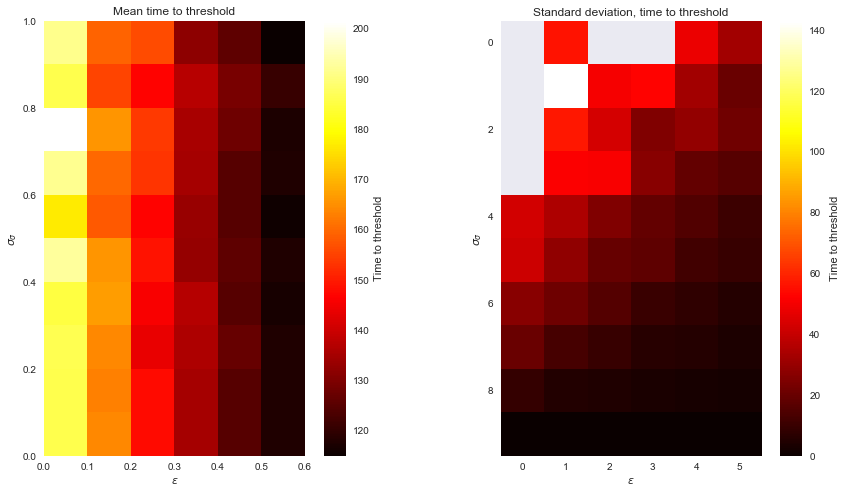

In [190]:
plt.figure(figsize=(15, 8))
plt.subplot('121')
plt.imshow(np.flipud(all_means), cmap=plt.cm.hot, extent=[0, 0.6, 0, 1])
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma_\sigma$')
plt.title('Mean time to threshold')
plt.grid(False)
plt.colorbar(label='Time to threshold')
#save_safe('time_to_thresh_sigma_sigma_ext_hot.pdf')

#plt.figure(figsize=(8, 8))
plt.subplot('122')
plt.imshow(np.flipud(all_std_devs), cmap=plt.cm.hot)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma_\sigma$')
plt.title('Standard deviation, time to threshold')
plt.grid(False)
plt.colorbar(label='Time to threshold')
save_safe('time_to_thresh_mean_sd__sigma_mu_ext_hot.pdf')

OSError: File exists!

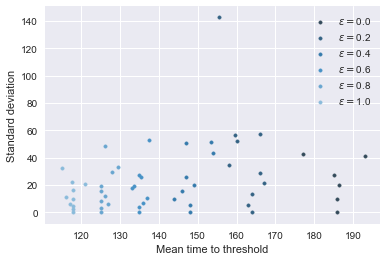

In [191]:
with sns.color_palette('Blues_d'):
    for iext in range(len(ext_lst)):
        mean_trial = all_means[:,iext].ravel()
        sd_trial = all_std_devs[:,iext].ravel()
        plt.scatter(mean_trial, sd_trial, marker='.', 
                    label=r'$\epsilon = $' + str(ext_lst[iext]))
        #regr = sklearn.linear_model.LinearRegression()
        #regr.fit(mean_trial[:20][:,np.newaxis], sd_trial[:20])
        #sd_pred = regr.predict(mean_trial[:,np.newaxis])
        #plt.plot(mean_trial, sd_pred)

#plt.ylim(0, 100)
#plt.xlim(0, 400)
plt.legend()
plt.xlabel('Mean time to threshold')
plt.ylabel('Standard deviation')
save_safe('mean_vs_std_sigma_sigma.pdf')

## Combined effect of $\sigma_\mu$ and $\sigma_\sigma$

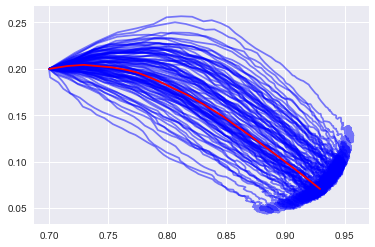

In [197]:
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': np.random.normal(loc=0, scale=0.3,
                                                    size=100), 'sigma': 0.1}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * 100), 'v': np.array([0.2] * 100)}
state_dict_single = {'u': np.array([0.7]), 'v': np.array([0.2])}

ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, 5000)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict_single, param_dict_no_noise, 5000)

plt.plot(ulst_noise, vlst_noise, 'b', alpha=0.5);
plt.plot(ulst_no_noise, vlst_no_noise, 'r');

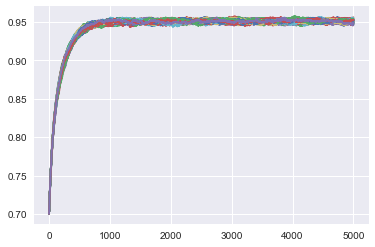

In [203]:
plt.plot(ulst_noise);

In [215]:
# Cumulative distributions
nsteps = 1000
ntrials = 1000
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}

# Plot the time stretch
noise_lst = np.linspace(0, 0.6, 20)
ext_lst = np.linspace(0, 1, 6)
tlength = np.nan
ncols = 2
nrows = 5


# Threshold for behavior
thresh = 0.85
action_times = np.zeros((len(noise_lst), ntrials))
palette = sns.color_palette("Blues_d", len(noise_lst))
all_means = np.zeros((len(noise_lst), len(noise_lst)))
all_std_devs = np.zeros((len(noise_lst), len(noise_lst)))

for imu, sigma_mu in enumerate(noise_lst):
    print('Working on sigma_mu = ', sigma_mu)
    for isig, sigma_sigma in enumerate(noise_lst):
        param_dict_noise['sigma'] = sigma_sigma
        param_dict_noise['ext'] = np.random.normal(loc=extern, scale=sigma_mu,
                                                  size=ntrials)
        ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)

        action_times = []
        # Find time to act
        for k in range(ntrials):
            # Check if the bound is reached (sometimes it's not!)
            if np.max(ulst_noise[:,k]) > thresh:
                action_times.append(np.nonzero(ulst_noise[:, k] > thresh)[0][0])
            else:
                action_times.append(np.inf)
                #print('Bound not reached')

        all_means[imu][isig] = np.median(action_times)
        all_std_devs[imu][isig] = np.std(action_times)

Working on sigma_mu =  0.0
Working on sigma_mu =  0.0315789473684
Working on sigma_mu =  0.0631578947368
Working on sigma_mu =  0.0947368421053
Working on sigma_mu =  0.126315789474
Working on sigma_mu =  0.157894736842
Working on sigma_mu =  0.189473684211
Working on sigma_mu =  0.221052631579
Working on sigma_mu =  0.252631578947
Working on sigma_mu =  0.284210526316
Working on sigma_mu =  0.315789473684
Working on sigma_mu =  0.347368421053
Working on sigma_mu =  0.378947368421
Working on sigma_mu =  0.410526315789
Working on sigma_mu =  0.442105263158
Working on sigma_mu =  0.473684210526
Working on sigma_mu =  0.505263157895


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Working on sigma_mu =  0.536842105263
Working on sigma_mu =  0.568421052632
Working on sigma_mu =  0.6


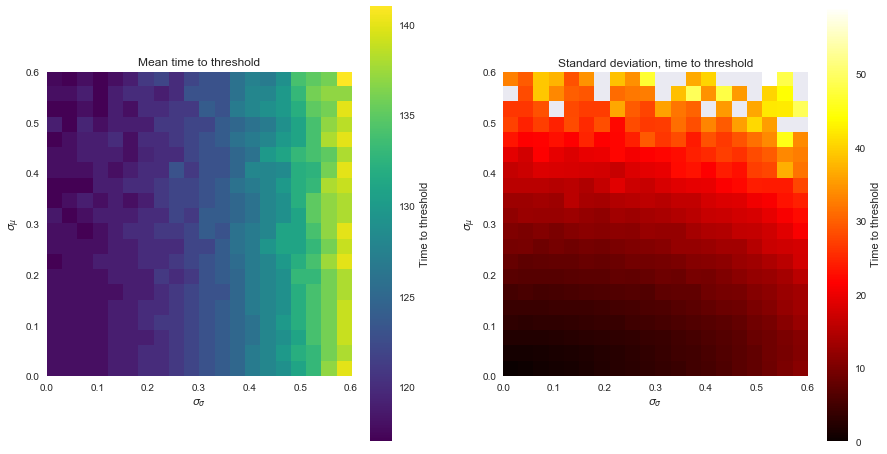

In [224]:
plt.figure(figsize=(15, 8))
plt.subplot('121')
plt.imshow(np.flipud(all_means), cmap=plt.cm.viridis, extent=[0, 0.6, 0, 0.6])
plt.ylabel(r'$\sigma_\mu$')
plt.xlabel(r'$\sigma_\sigma$')
plt.title('Mean time to threshold')
plt.grid(False)
plt.colorbar(label='Time to threshold')
#save_safe('time_to_thresh_sigma_sigma_ext_hot.pdf')

#plt.figure(figsize=(8, 8))
plt.subplot('122')
plt.imshow(np.flipud(all_std_devs), cmap=plt.cm.hot, extent=[0, 0.6, 0, 0.6])
plt.ylabel(r'$\sigma_\mu$')
plt.xlabel(r'$\sigma_\sigma$')
plt.title('Standard deviation, time to threshold')
plt.grid(False)
plt.colorbar(label='Time to threshold')
save_safe('time_to_thresh_sigma_sigma__sigma_mu_ext_hot.pdf')